In [1]:
%pylab notebook
import sympy as sp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import numpy as np

h=6.62607004e-34 #Plancks constant #m2 kg / s
k=1.38064852e-23 #Boltzmann constant #m2 kg s-2 K-1
ghz2hz=1e9
x=logspace(log10(20),log10(3000),500)

Populating the interactive namespace from numpy and matplotlib


1.0 12.9898662496 270.664805898


<IPython.core.display.Javascript object>


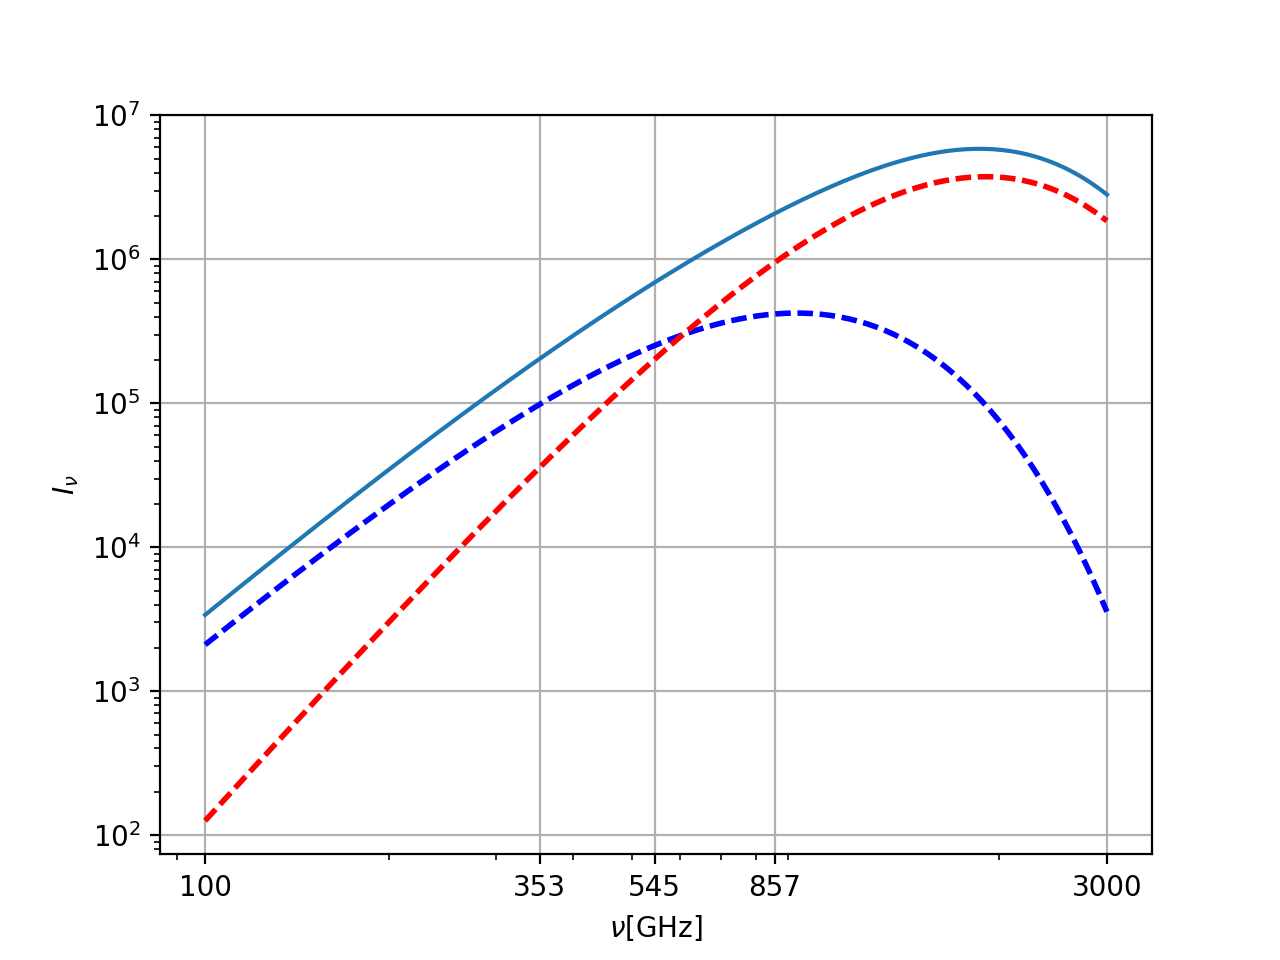

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


([<matplotlib.axis.XTick at 0x117a71510>,
 <a list of 5 Text xticklabel objects>)

In [2]:
def mbb(nu,T,A,alpha,nu0=1.):
    x=h*nu*1e9/(k*T)
    Inu=A*((nu/nu0)**alpha)*(nu**3.)/(np.exp(x)-1.)
    return Inu

def multitemp_mbb_spectra(nu,T1,A1,alpha1,T2,A2,alpha2,nu0=1.):
    Inu=mbb(nu,T1,A1,alpha1,nu0=nu0) + mbb(nu,T2,A2,alpha2,nu0=nu0)
    return Inu

f=0.34188
T1=9.75 ; A1=f; alpha1=1.63; T2=15.7 ; A2 =(1.-f); alpha2=2.82

Abar=A1+A2
Tbar=Abar/((A1/T1)+(A2/T2))
nu0=k*Tbar/h/1e9
print Abar,Tbar,nu0

x=logspace(log10(100),log10(3000),200)
Inu=multitemp_mbb_spectra(x,T1,A1,alpha1,T2,A2,alpha2,nu0=3000.)


fn=interp1d(x,Inu,kind="quadratic") ; norm=3388/fn(100.)
Inu=Inu*norm

figure()
plot(x,Inu)
plot(x,mbb(x,T1,A1,alpha1,nu0=3000.),"b--",lw=2)
plot(x,mbb(x,T2,A2,alpha2,nu0=3000.),"r--",lw=2)
loglog()
ylabel(r"$I_{\nu}$")
xlabel(r"$\nu$[GHz]")
grid()
legend(loc=0)
xticks([100,353,545,857,3000],[100,353,545,857,3000])

In [4]:
nu,nu0,s,beta,c0=sp.symbols("nu nu0 s beta c0")

mbb=((nu/nu0)**s)*(nu**3.)/(sp.exp(c0*nu*beta)-1.)

def mbb_der(der_beta=0,der_s=0):
    '''This function returns the requisite derivative of the base SED'''
    expr=mbb.diff(beta,der_beta)*mbb.diff(s,der_s)*(beta**der_beta)/mbb/(sp.factorial(der_beta)*sp.factorial(der_s))
    return expr

def taylor_series(n):
    fn=0.
    for der in range(n+1):
        for der_T in range(der+1):
            der_s=abs(der-der_T)
            print der,der_T,der_s
            fn = fn + mbb_der(der_T,der_s)
    return fn

fn_dir={}
def create_fn_dir(n):
    '''This function creates a directory of functions \n These function are the various derivatives of the base SED'''
    counter=0
    for der in range(n+1):
        for der_T in range(der+1):
            der_s=abs(der-der_T)
            print counter,der_T,der_s,mbb_der(der_T,der_s)/mbb_der()
            fn=sp.lambdify((nu,beta,s,nu0,c0),mbb_der(der_T,der_s),modules="numpy")
            fn_dir[counter]=fn
            counter=counter+1
    print counter

create_fn_dir(3)
len(fn_dir)

def moment_exact(x,*params):
    '''Pass a minimum to 3 parameters: (T, slope,A) to *argv else this function will fail.\n
    Pass 3 parameters to fit a MBB sed.
    Pass 6 parameters to fit a MBB with second derivative functions.
    Pass 10 parameters to fit a MBB with thridd derivative functions.
    '''
    T=params[0] ; slope=params[1] ; A=params[2]
    nu0=k*T/h/ghz2hz ; c0=h*ghz2hz/k

    y=A*fn_dir[0](x,1./T,slope,nu0,c0)
    for i, arg in enumerate(params[3:]):
        # 3+i is to exclude 1st derivative terms.
        y=y+A*arg*fn_dir[3+i](x,1./T,slope,nu0,c0)
    return y

def moment_perturbative(x,T,slope,A,*params):
    nu0=k*T/h ; c0=h*1e9/k
    y=0.
    for i, par in enumerate(params):
        y=y+par*fn_dir[i](x,1./T,slope,nu0,c0)
    return A*y

0 0 0 1
1 0 1 log(nu/nu0)
2 1 0 -beta*c0*nu**1.0*exp(beta*c0*nu)/(exp(beta*c0*nu) - 1.0)
3 0 2 log(nu/nu0)**2/2
4 1 1 -beta*c0*nu**1.0*exp(beta*c0*nu)*log(nu/nu0)/(exp(beta*c0*nu) - 1.0)
5 2 0 beta**2*c0**2*nu**2.0*(-1 + 2*exp(beta*c0*nu)/(exp(beta*c0*nu) - 1.0))*exp(beta*c0*nu)/(2*(exp(beta*c0*nu) - 1.0))
6 0 3 log(nu/nu0)**3/6
7 1 2 -beta*c0*nu**1.0*exp(beta*c0*nu)*log(nu/nu0)**2/(2*(exp(beta*c0*nu) - 1.0))
8 2 1 beta**2*c0**2*nu**2.0*(-1 + 2*exp(beta*c0*nu)/(exp(beta*c0*nu) - 1.0))*exp(beta*c0*nu)*log(nu/nu0)/(2*(exp(beta*c0*nu) - 1.0))
9 3 0 beta**3*c0**3*nu**3.0*(-1 + 6*exp(beta*c0*nu)/(exp(beta*c0*nu) - 1.0) - 6*exp(2*beta*c0*nu)/(exp(beta*c0*nu) - 1.0)**2)*exp(beta*c0*nu)/(6*(exp(beta*c0*nu) - 1.0))
10


In [5]:
def y1(x):
    return x*exp(x)/(exp(x)-1.)

def y2(x):
    return y1(x)*x*cosh(0.5*x)/sinh(0.5*x)

def y3(x):
    return y1(x)*x*x*(cosh(x)+2)/(cosh(x)-1)

def y4(x):
    return y2(x)*0.5*x*x*(cosh(x)+5)/(sinh(0.5*x)**2.)

def y5(x):
    return y1(x)*(x**4.)*(33.+26*cosh(x)+cosh(2.*x))/(8.*sinh(0.5*x)**4.)

def f_mbb(nu,T,alpha,A,p22=0,p23=0,p33=0,p222=0,p223=0,p233=0,p333=0):
    x=h*nu*1e9/k/T
    nu0=k*T/h/1e9
    I0=A*(((nu/nu0)**alpha)*(nu**3.))/(exp(x)-1.)
    temp=I0*(1. + 0.5*p22*(log(nu/nu0))**2. - p23*log(nu/nu0)*y1(x)+ 0.5*p33*y2(x))
    temp = temp +  I0*(p222*(log(nu/nu0)**3.)/6. - 0.5*p223*(log(nu/nu0)**2.)*y1(x) + 0.5*p233*log(nu/nu0)*y2(x) - p333*y3(x)/6.)
    return temp

<IPython.core.display.Javascript object>


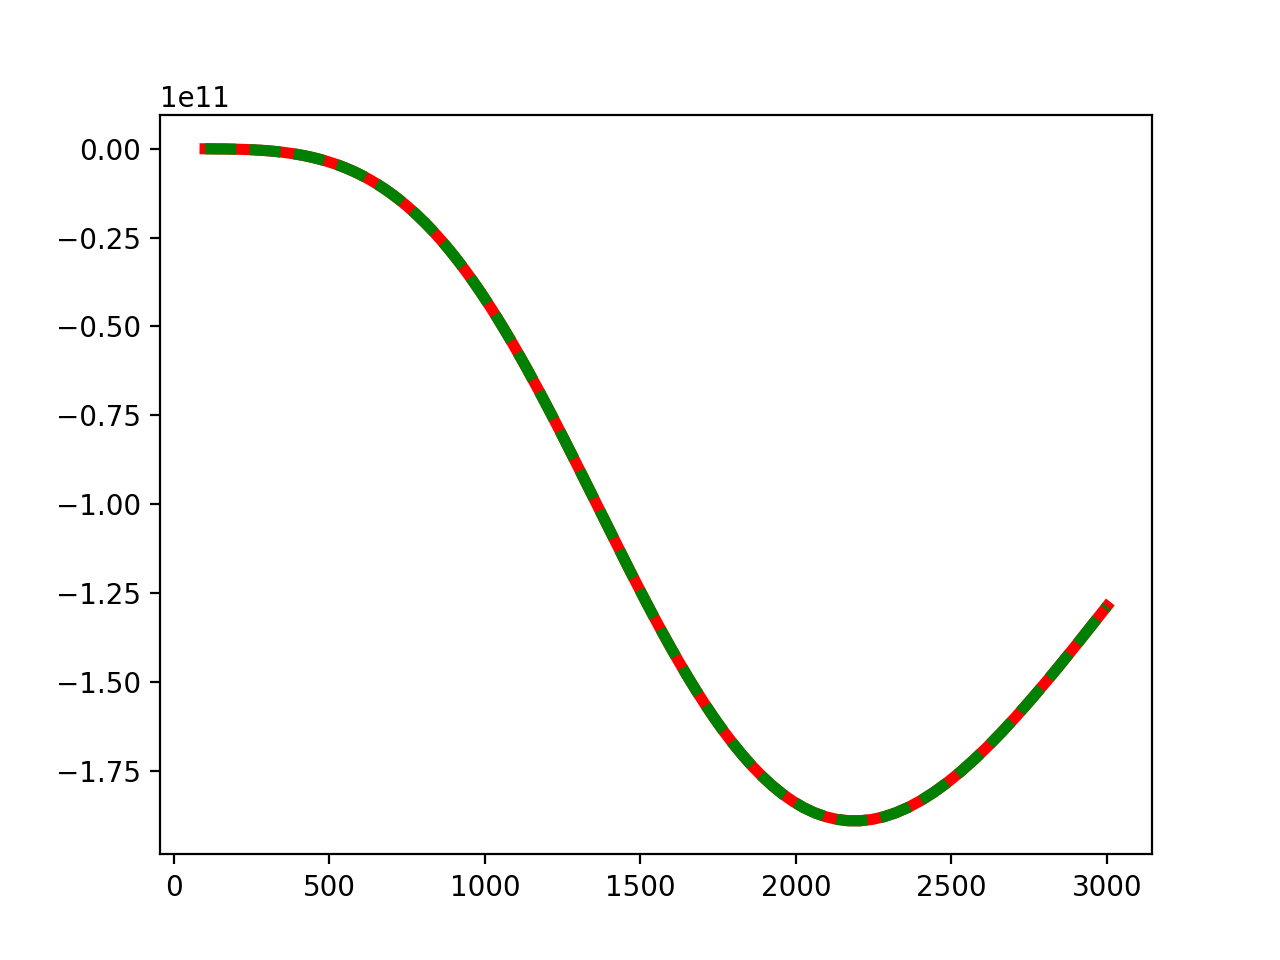

In [6]:
T=15. ; slope=1.
figure()
plot(x,f_mbb(x,T,slope,50.,p333=1),"r-",lw=4)
plot(x,moment_exact(x,T,slope,50.,0,0,0,0,0,0,1.),"g--",lw=4)

In [7]:
p0=(30.,0.,1e-6)
lb0=(0., -3.,0.) ; ub0=(100,3.,10.)
fitp0,cov=curve_fit(moment_exact,x,Inu,p0=p0,maxfev=200000)
print fitp0

prange=2.

x1=x[x>=300] ; Inu1=Inu[x>=300]
lb2=append(lb0,[-prange,-prange,-prange])
ub2=append(ub0,[prange,prange,prange])
fitp2,cov=curve_fit(moment_exact,x1,Inu1,p0=[2,0,1.,0.,0.,0.],maxfev=200000)
print fitp2

x2=x[x<=2000] ; Inu2=Inu[x<=2000]
lb3=append(lb2,[-prange,-prange,-prange,-prange])
ub3=append(ub2,[prange,prange,prange,prange])
p0=(5.,1.,1.,0.,0.,0.,0.,0.,0.,0.)
fitp3,cov=curve_fit(moment_exact,x2,Inu2,p0=p0,maxfev=200000)
print fitp3

[  1.84517946e+01   1.81945271e+00   6.39219713e-03]
[  1.53871415e+01   1.22059935e+00   5.89674720e-03  -6.56381152e-01
  -2.53903605e-01   1.98477905e-01]


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in power
  """
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in power
  """
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in log
  """
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in power
  """
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in log
  """
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in power
  """
/Users/adityarotti/L

[  1.33357594e+01   2.02206018e+00   3.74079488e-03  -4.32779956e-02
   4.85434557e-01   5.45548984e-01  -6.74098122e-03  -5.39979800e-01
  -3.37061418e-01  -1.00605551e-01]


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in power
  """
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in log
  """
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in power
  """
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in log
  """
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in power
  """


<IPython.core.display.Javascript object>


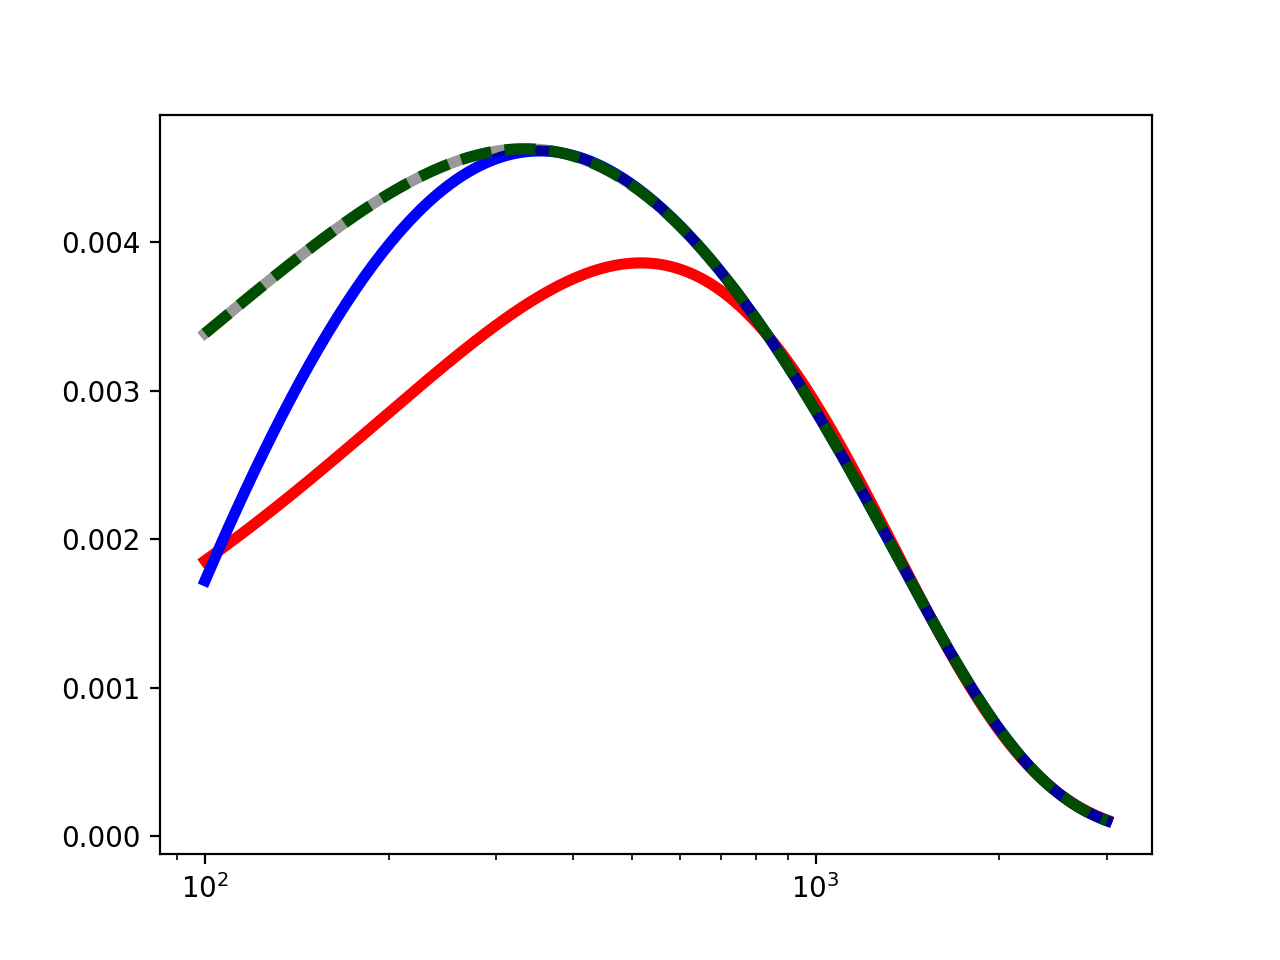

[]

In [20]:
figure()
plot(x,moment_exact(x,*fitp0)/(x**3),"r-",lw=4)
plot(x,moment_exact(x,*fitp2)/(x**3),"b-",lw=4)
plot(x,moment_exact(x,*fitp3)/(x**3),"g--",lw=4)
plot(x,Inu/(x**3),"k-",alpha=0.4,lw=4)
semilogx()

In [21]:
def nmbb(nu,T,alpha,nu0=1.):
    x=h*nu*1e9/(k*T)
    Inu=((nu/nu0)**alpha)*(nu**3.)/(exp(x)-1.)
    return Inu

def fn(nu,beta,s,nu0,c0,*args):
    temp=sp.lambdify((nu,beta,s,nu0,c0),mbb_der(0,0),modules="numpy")(nu,beta,s,nu0,c0)
    for i,arg in enumerate(args):
        temp=temp+ arg*sp.lambdify((nu,beta,s,nu0,c0),mbb_der(i,0),modules="numpy")
    return temp

In [109]:
d={}
def create_fn_dir(n):
    for i in range(n):
        fn=sp.lambdify((nu,beta,s,nu0,c0),mbb_der(i,0),modules="numpy")
        d[i]=fn

create_fn_dir(5)        

def wlc(x,T,slope,nu0,c0,*argv):
    temp=d[0](x,1./T,slope,nu0,c0)
    for i, arg in enumerate(argv):
        temp=temp+arg*d[i](x,1./T,slope,nu0,c0)
    return temp

In [110]:
T=15. ; slope=0.
y=nmbb(x,T,slope)
y1=d[1](x,1./T,slope,1.,h*1e9/k)

<IPython.core.display.Javascript object>


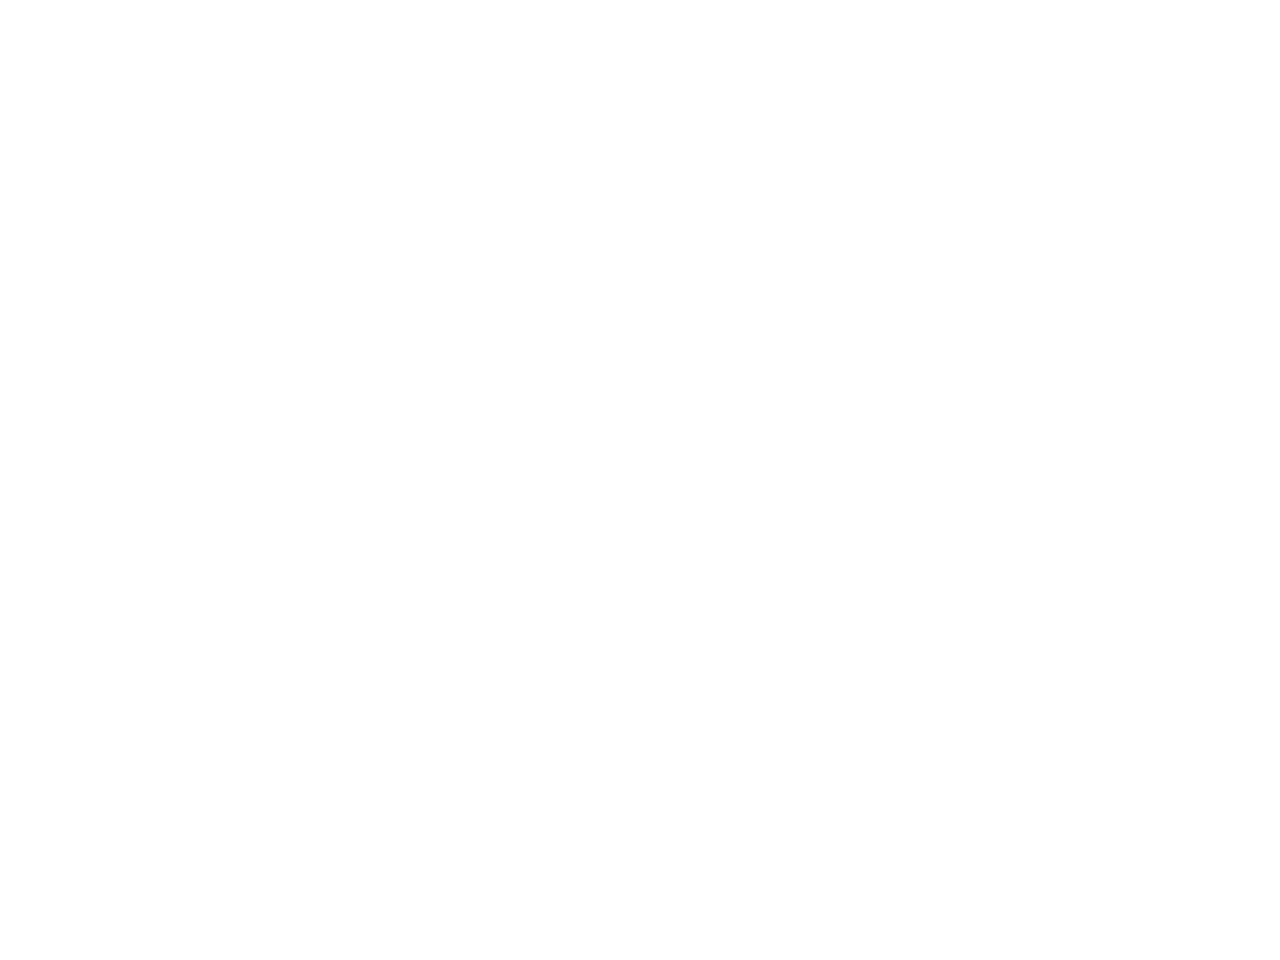

KeyError: 5

In [127]:
figure()
plot(x,y,"r-")
plot(x,d[0](x,1./T,slope,1.,h*1e9/k),"g--")
plot(x,wlc(x,T,slope,1.,h*1e9/k,-0.0,0.1),"m-")
plot(x,wlc(x,T,slope,1.,h*1e9/k,0.1,0.1,0.1,0.1,0.001,0.01),"c-")

<IPython.core.display.Javascript object>


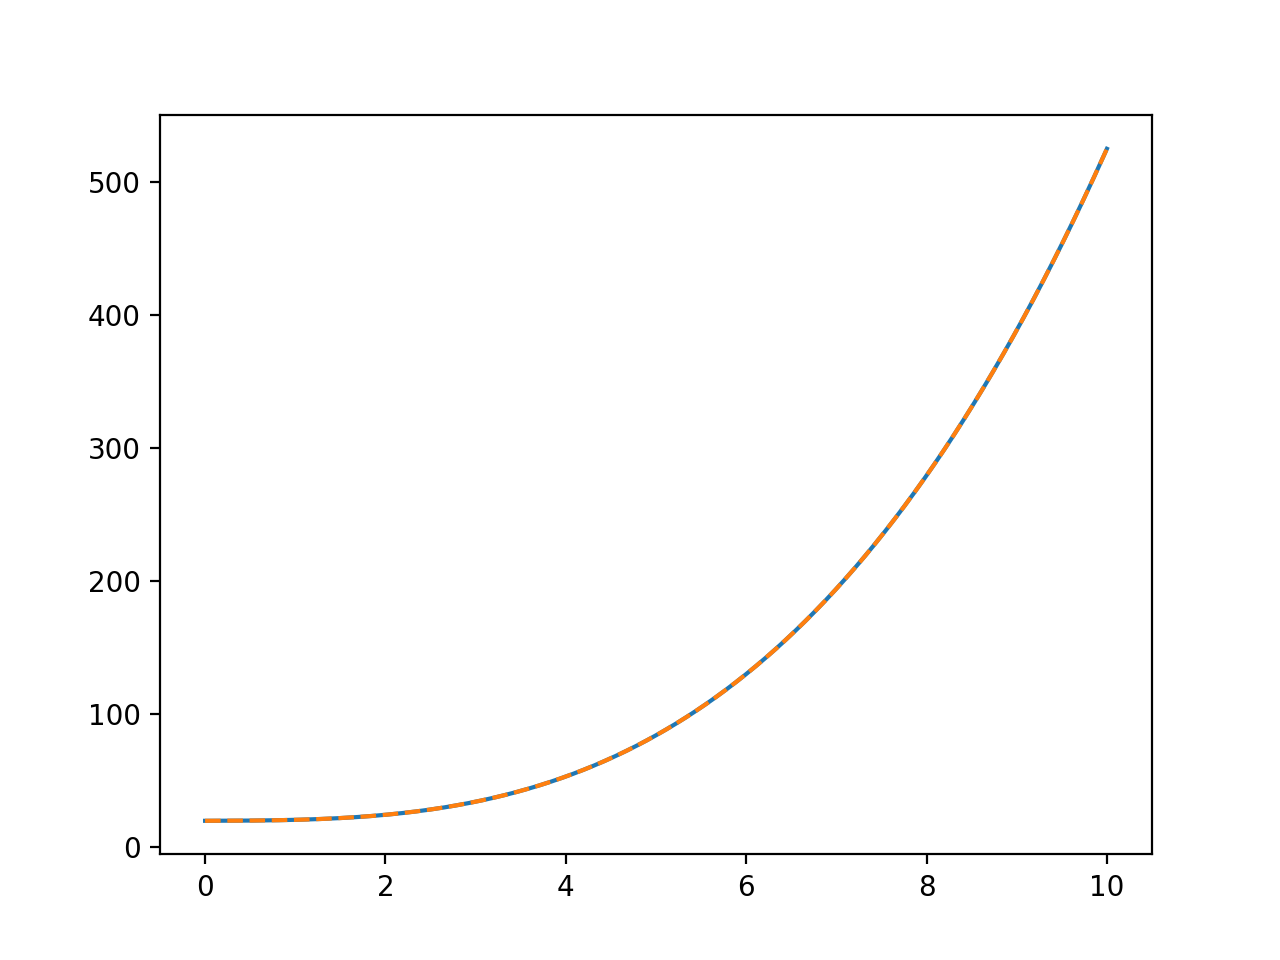

array([ 20.  ,   0.2 ,   0.03,   0.5 ])

In [110]:
x=linspace(0,10,1000)
y=20. + 0.2*x + 0.03*x**2 + 0.5*x**3

def fitfn(x,*argv):
    y=0.
    for i,arg in enumerate(argv):
        y=y+arg*x**(float(i))
    return y

figure()
plot(x,y)
plot(x,fitfn(x,20.,0.2,0.03,0.5),"--")

p0=[0,0,0,0]
fitp,fitcov=curve_fit(fitfn,x,y,p0=p0)
fitp

In [113]:
#def nmbb(nu,T,alpha,nu0=1.):
def nmbb(nu,*par):
    print np.size(par[0])
    print par[0][0]
    T=par[0][0] ; alpha=par[0][1] ; nu0=par[0][2] ; c0=h*1e9/k
    moments=par[0][3:] ; print moments
    print T,alpha,nu0
    x=h*nu*1e9/(k*T)
    Inu=((nu/nu0)**alpha)*(nu**3.)/(np.exp(c0*nu/T)-1.)
    return Inu

<IPython.core.display.Javascript object>


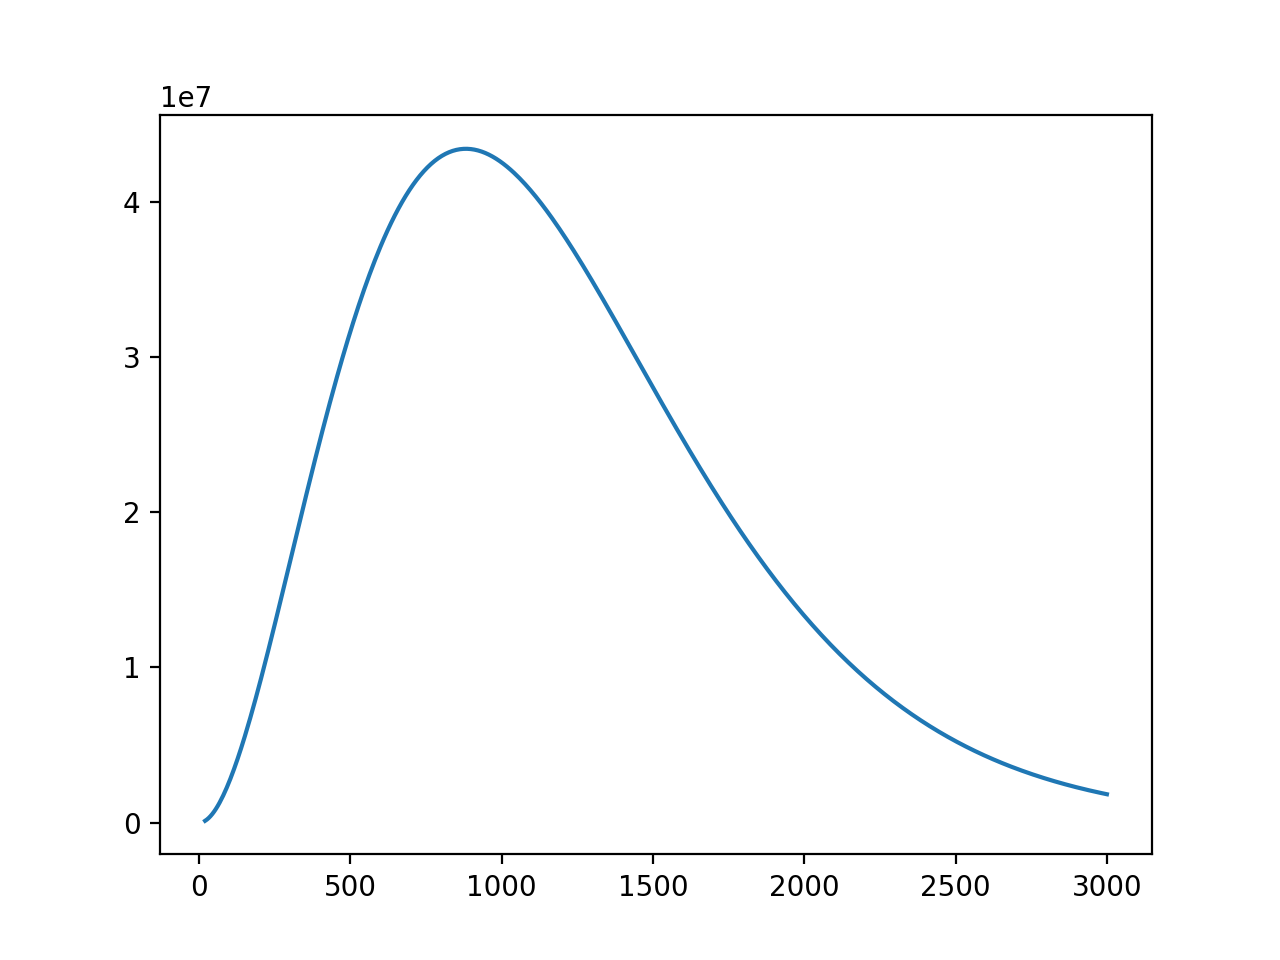

6
15.0
[0, 1, 2]
15.0 0.0 1.0


In [114]:
x=linspace(20,3000,500)
T=15. ; slope=0. ; nu0=1.
par=[T,slope,nu0,0,1,2]

figure()
plot(x,nmbb(x,par))

In [120]:
par

[15.0, 0.0, 1.0, 0, 1, 2]